# Adım 2: Kendi Verisetimizle Eğitim (Custom Training)

Bu notebook'ta, önceden eğitilmiş bir modeli (RTMDet) alıp, kendi özel verisetimiz (**Balloon Dataset**) üzerinde tekrar eğiteceğiz (Fine-tuning).

### Hedefler:
1.  **Veri Hazırlığı:** Verisetini indirmek, incelemek ve MMDetection'a uygun formata (COCO formatı) dönüştürmek.
2.  **Config Düzenleme:** Modelin konfigürasyon dosyasını kendi verisetimize ve donanımımıza göre modifiye etmek.
3.  **Eğitim (Training):** Modeli yeni verilerle eğitmek.
4.  **Test (Inference):** Eğitilen modelin başarısını yeni resimler üzerinde test etmek.

### Kullanılan Model: RTMDet
Bu örnekte **RTMDet (Real-time Object Detector)** modelini kullanacağız.

**Nedir?**
OpenMMLab (MMDetection) ekibi tarafından geliştirilen, hem çok hızlı (Real-Time) hem de yüksek doğruluk oranına sahip modern bir nesne tespit modelidir.

**Neden Seçtik?**
1.  **Hız:** Laptop gibi GPU'su olmayan veya düşük olan cihazlarda bile makul hızda çalışır.
2.  **Performans:** YOLO serisi modellerle (YOLOv5, v8 vb.) yarışır performansa sahiptir.
3.  **Mimari:** Anchor-free (çapa kutusu olmayan) yapısı sayesinde parametre ayarı gerektirmez ve kullanımı kolaydır.

## 1. Verisetinin İndirilmesi ve Hazırlanması

İlk olarak, örnek verisetimiz olan "Balloon Dataset"i indireceğiz. Bu veriseti oldukça küçüktür ve eğitim/test işlemleri için idealdir.

In [2]:
import os
import urllib.request
import zipfile
import shutil

# Veriseti kök dizini
data_root = 'data/balloon'

# Eğer klasör yoksa oluştur
if not os.path.exists(data_root):
    os.makedirs(data_root, exist_ok=True)

# İndirme bağlantısı (Matterport Balloon Dataset)
url = 'https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip'
zip_path = 'data/balloon_dataset.zip'

if not os.path.exists(os.path.join(data_root, 'train')):
    print("Veriseti indiriliyor...")
    urllib.request.urlretrieve(url, zip_path)
    print("İndirme tamamlandı. Dosya açılıyor...")

    # Zip dosyasını aç
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data/')

    # Zip'i sil
    if os.path.exists(zip_path):
        os.remove(zip_path)
    
    print(f"Veriseti '{data_root}' klasörüne başarıyla hazırlandı!")
else:
    print(f"Veriseti '{data_root}' altında zaten mevcut. İndirme atlandı.")

## 2. Verisetini İnceleme

Verisetinin doğru inip inmediğini ve klasör yapısını kontrol edelim. Genellikle `train` (eğitim) ve `val` (doğrulama) olmak üzere iki alt klasör bekleriz.

In [3]:
# Klasör içeriğini listele
print(f"Ana Dizin ({data_root}):", os.listdir(data_root))

train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'val')

if os.path.exists(train_dir):
    print(f"Train Klasörü ({len(os.listdir(train_dir))} dosya):", os.listdir(train_dir)[:3], "...")

if os.path.exists(val_dir):
    print(f"Val Klasörü ({len(os.listdir(val_dir))} dosya):", os.listdir(val_dir)[:3], "...")

### Önemli Not: Veri Formatı
İndirdiğimiz Balloon veriseti **VIA (VGG Image Annotator)** formatındadır. (Her klasörde `via_region_data.json` adında bir dosya görürsünüz).

Ancak MMDetection (ve RTMDet), **COCO Formatını** tercih eder. Bu yüzden bir sonraki adımda bu JSON dosyalarını COCO formatına dönüştüren bir script yazacağız.

## 3. Format Dönüştürme: VIA'dan COCO Formatına

Balon veriseti "Instance Segmentation" için tasarlandığı için etiketler polygon (çokgen) şeklindedir. Biz ise bunları "Object Detection" için **Bounding Box (Sınırlayıcı Kutu)** formatına çevireceğiz.

In [4]:
import json

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    """
    VIA formatındaki (balloon) etiket dosyasını COCO formatına çevirir.
    """
    print(f"{ann_file} okunuyor...")
    with open(ann_file) as f:
        data_infos = json.load(f)

    annotations = []
    images = []
    obj_count = 0
    
    # Dictionary'nin değerlerini dolaş (key'ler image_id'dir)
    # data_infos bir dict: {'filename1': {attributes}, ...}
    for idx, v in enumerate(data_infos.values()):
        filename = v['filename']
        img_path = os.path.join(image_prefix, filename)
        
        # Resim boyutlarını al (Eğer dosya yoksa hata verebilir, kontrol edelim)
        # Not: Pillow kütüphanesi ile resim boyutunu okuyabilirsiniz, 
        # ancak basitlik adına burada statik veya cv2 ile dinamik alabiliriz.
        # Burada cv2 ile okuyup height/width almak en garantisidir.
        import cv2
        img = cv2.imread(img_path)
        height, width = img.shape[:2]

        # COCO Image formatı
        images.append(dict(
            id=idx,
            file_name=filename,
            height=height,
            width=width))

        # Her bir resimdeki bölgeleri (regions) dolaş
        for _, obj in v['regions'].items():
            assert not obj['region_attributes'] # Balloon setinde attribute yoktur
            
            # Polygon noktalarını al (x ve y listeleri)
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            
            # Polygon'dan Bounding Box hesapla (en küçük x, en büyük x vs.)
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            
            x_min, y_min = min(px), min(py)
            x_max, y_max = max(px), max(py)
            
            w = x_max - x_min
            h = y_max - y_min
            
            # COCO Annotation formatı
            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0, # Tek sınıfımız var (Balloon), ID'si 0 olsun
                bbox=[x_min, y_min, w, h],
                area=w * h,
                segmentation=[poly], # Maske için gerekli (RTMDet kullanmasa da bulunsun)
                iscrowd=0)
            
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{'id': 0, 'name': 'balloon'}])
    
    # Yeni JSON dosyasını kaydet
    with open(out_file, 'w') as f:
        json.dump(coco_format_json, f)
    
    print(f"Dönüştürme tamamlandı! Çıktı: {out_file}")

# Dönüştürme işlemini train ve val için çalıştır
convert_balloon_to_coco(
    ann_file=os.path.join(data_root, 'train', 'via_region_data.json'),
    out_file=os.path.join(data_root, 'train', 'annotation_coco.json'),
    image_prefix=os.path.join(data_root, 'train'))

convert_balloon_to_coco(
    ann_file=os.path.join(data_root, 'val', 'via_region_data.json'),
    out_file=os.path.join(data_root, 'val', 'annotation_coco.json'),
    image_prefix=os.path.join(data_root, 'val'))

## 4. Config ve Checkpoint Dosyalarını İndirme

Model dosyaları bilgisayarımızda hazır olmadığı için, OpenMMLab'ın paket yöneticisi `mim` kullanarak gerekli dosyaları indireceğiz. Böylece tüm repoyu klonlamamıza gerek kalmayacak.

In [ ]:
from mmengine.utils import get_git_hash
from mmdet.utils import register_all_modules
from mim import download

# Config dosya ADI (uzantısız) - MIM için gereklidir
config_name = 'rtmdet_tiny_8xb32-300e_coco'
checkpoint_file = 'rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e63d96.pth'

# MIM ile indir 
# configs dizisine dosya adını veriyoruz, bize inen dosyanın tam yolunu dönüyor
config_path = download(package='mmdet', configs=[config_name], dest_root='.')

print(f'Config indirildi: {config_path[0]}')
print(f'Dosyanın tam yolu: {config_path[0]}')

## 5. Config Dosyasının Düzenlenmesi

Şimdi indirdiğimiz `rtmdet_tiny` config dosyasını kendi verisetimize (Balloon) uyarlayacağız.

In [3]:
from mmengine import Config

# 1. Config dosyasını yükle
try:
    # mim.download bazen sadece checkpoint yolunu listeye koyabiliyor
    # bu yüzden indirilen config dosyasının varsayılan adını kullanıyoruz
    cfg_file_path = 'rtmdet_tiny_8xb32-300e_coco.py'
    cfg = Config.fromfile(cfg_file_path)
except Exception as e:
    print(f"Hata oluştu: {e}")
    print("Manuel config yolu deneniyor...")
    # Alternatif deneme (varsayılan indirme konumu)
    try:
        if 'config_path' in locals() and len(config_path) > 0:
             # Eğer listedeki ilk eleman .py ise onu kullan
             if config_path[0].endswith('.py'):
                 cfg = Config.fromfile(config_path[0])
             else:
                 raise ValueError("Config dosyası bulunamadı")
    except:
        raise FileNotFoundError("Config dosyası yüklenemedi. Lütfen dosyanın indirildiğinden emin olun.")

# 2. Temel Ayarlar (Data Root, Class Names)
cfg.dataset_type = 'CocoDataset'
cfg.data_root = 'data/balloon/'
cfg.metainfo = {
    'classes': ('balloon', ),
    'palette': [ (220, 20, 60) ]
}

# 3. Model Başlık (Head) Ayarı
# Sadece 1 sınıfımız var (Balloon)
cfg.model.bbox_head.num_classes = 1

# 4. Dataloader (Veri Yükleyici) Ayarları
# Train (Eğitim) seti
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.ann_file = 'train/annotation_coco.json'
cfg.train_dataloader.dataset.data_prefix = dict(img='train/')
cfg.train_dataloader.dataset.metainfo = cfg.metainfo

# Val (Doğrulama) seti
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.ann_file = 'val/annotation_coco.json'
cfg.val_dataloader.dataset.data_prefix = dict(img='val/')
cfg.val_dataloader.dataset.metainfo = cfg.metainfo

# Windows dataloader hatası için worker sayısını düşürelim
cfg.train_dataloader.num_workers = 0
cfg.val_dataloader.num_workers = 0

# Test seti (Val ile aynı)
cfg.test_dataloader = cfg.val_dataloader

# 5. Evaluation (Değerlendirme) Ayarı
cfg.val_evaluator.ann_file = cfg.data_root + 'val/annotation_coco.json'
cfg.test_evaluator = cfg.val_evaluator

# 6. Eğitim Parametreleri
# Orijinalinde 300 epoch var, bu çok uzun sürer. 
# Balon veriseti küçük olduğundan 20-40 epoch yeterlidir.
cfg.train_cfg.max_epochs = 40

cfg.default_hooks.checkpoint.interval = 10  # Her 10 epochta bir model kaydet
cfg.default_hooks.checkpoint.max_keep_ckpts = 1  # Sadece en son 1 modeli sakla (Disk tasarrufu)
cfg.default_hooks.checkpoint.save_best = 'auto' # En iyi modeli otomatik belirle

# Learning Rate (Öğrenme Hızı) Ayarı
cfg.optim_wrapper.optimizer.lr = 0.002

# Log (Kayıt) Ayarları
cfg.default_hooks.logger.interval = 10  # Her 10 adımda bir log bas

# Resume (Kaldığı yerden devam et)
# Eğer eğitim yarıda kesildiyse, son checkpoint'ten devam eder.
cfg.resume = True

# Çalışma Klasörü (Sonuçlar buraya kaydedilecek)
cfg.work_dir = './tutorial_exps/balloon_rtmdet'

# Config'i dosyaya kaydet (İncelemek istersek diye)
# Önce klasörün var olduğundan emin ol
import os
if not os.path.exists(cfg.work_dir):
    os.makedirs(cfg.work_dir)

cfg.dump(f'{cfg.work_dir}/rtmdet_tiny_balloon.py')

print(f"Config başarıyla güncellendi ve şuraya kaydedildi: {cfg.work_dir}/rtmdet_tiny_balloon.py")

## 6. Eğitimi Başlatma (Training)

Tüm ayarlarımız hazır! Şimdi MMDetection'ın `Runner` modülünü kullanarak eğitimi başlatacağız.
Bu işlem, belirlediğimiz epoch sayısı kadar sürecektir (40 epoch kısa sürer).

In [ ]:
from mmengine.runner import Runner

# Config dosyasını çalışma dizininden tekrar yükle 
# (Yukarıdaki işlemlerin diske yazdığı dosyayı kullanıyoruz)
cfg_path = f'{cfg.work_dir}/rtmdet_tiny_balloon.py'
cfg = Config.fromfile(cfg_path)

# Runner'ı başlat
runner = Runner.from_cfg(cfg)

# Eğitimi başlat! (Bu işlem biraz zaman alabilir)
runner.train()

## 7. Sonuçları Test Etme (Inference)

Eğitim tamamlandıktan sonra, modelin hiç görmediği doğrulama (val) setinden bir resim üzerinde ne kadar başarılı olduğunu görelim.

En son epoch yükleniyor: epoch_40.pth
Loads checkpoint by local backend from path: ./tutorial_exps/balloon_rtmdet\epoch_40.pth
Toplam 13 adet test görseli bulundu. İşleniyor...
Sonuçlar 'demo/finetune_output_results' klasörüne de kaydedilecek.


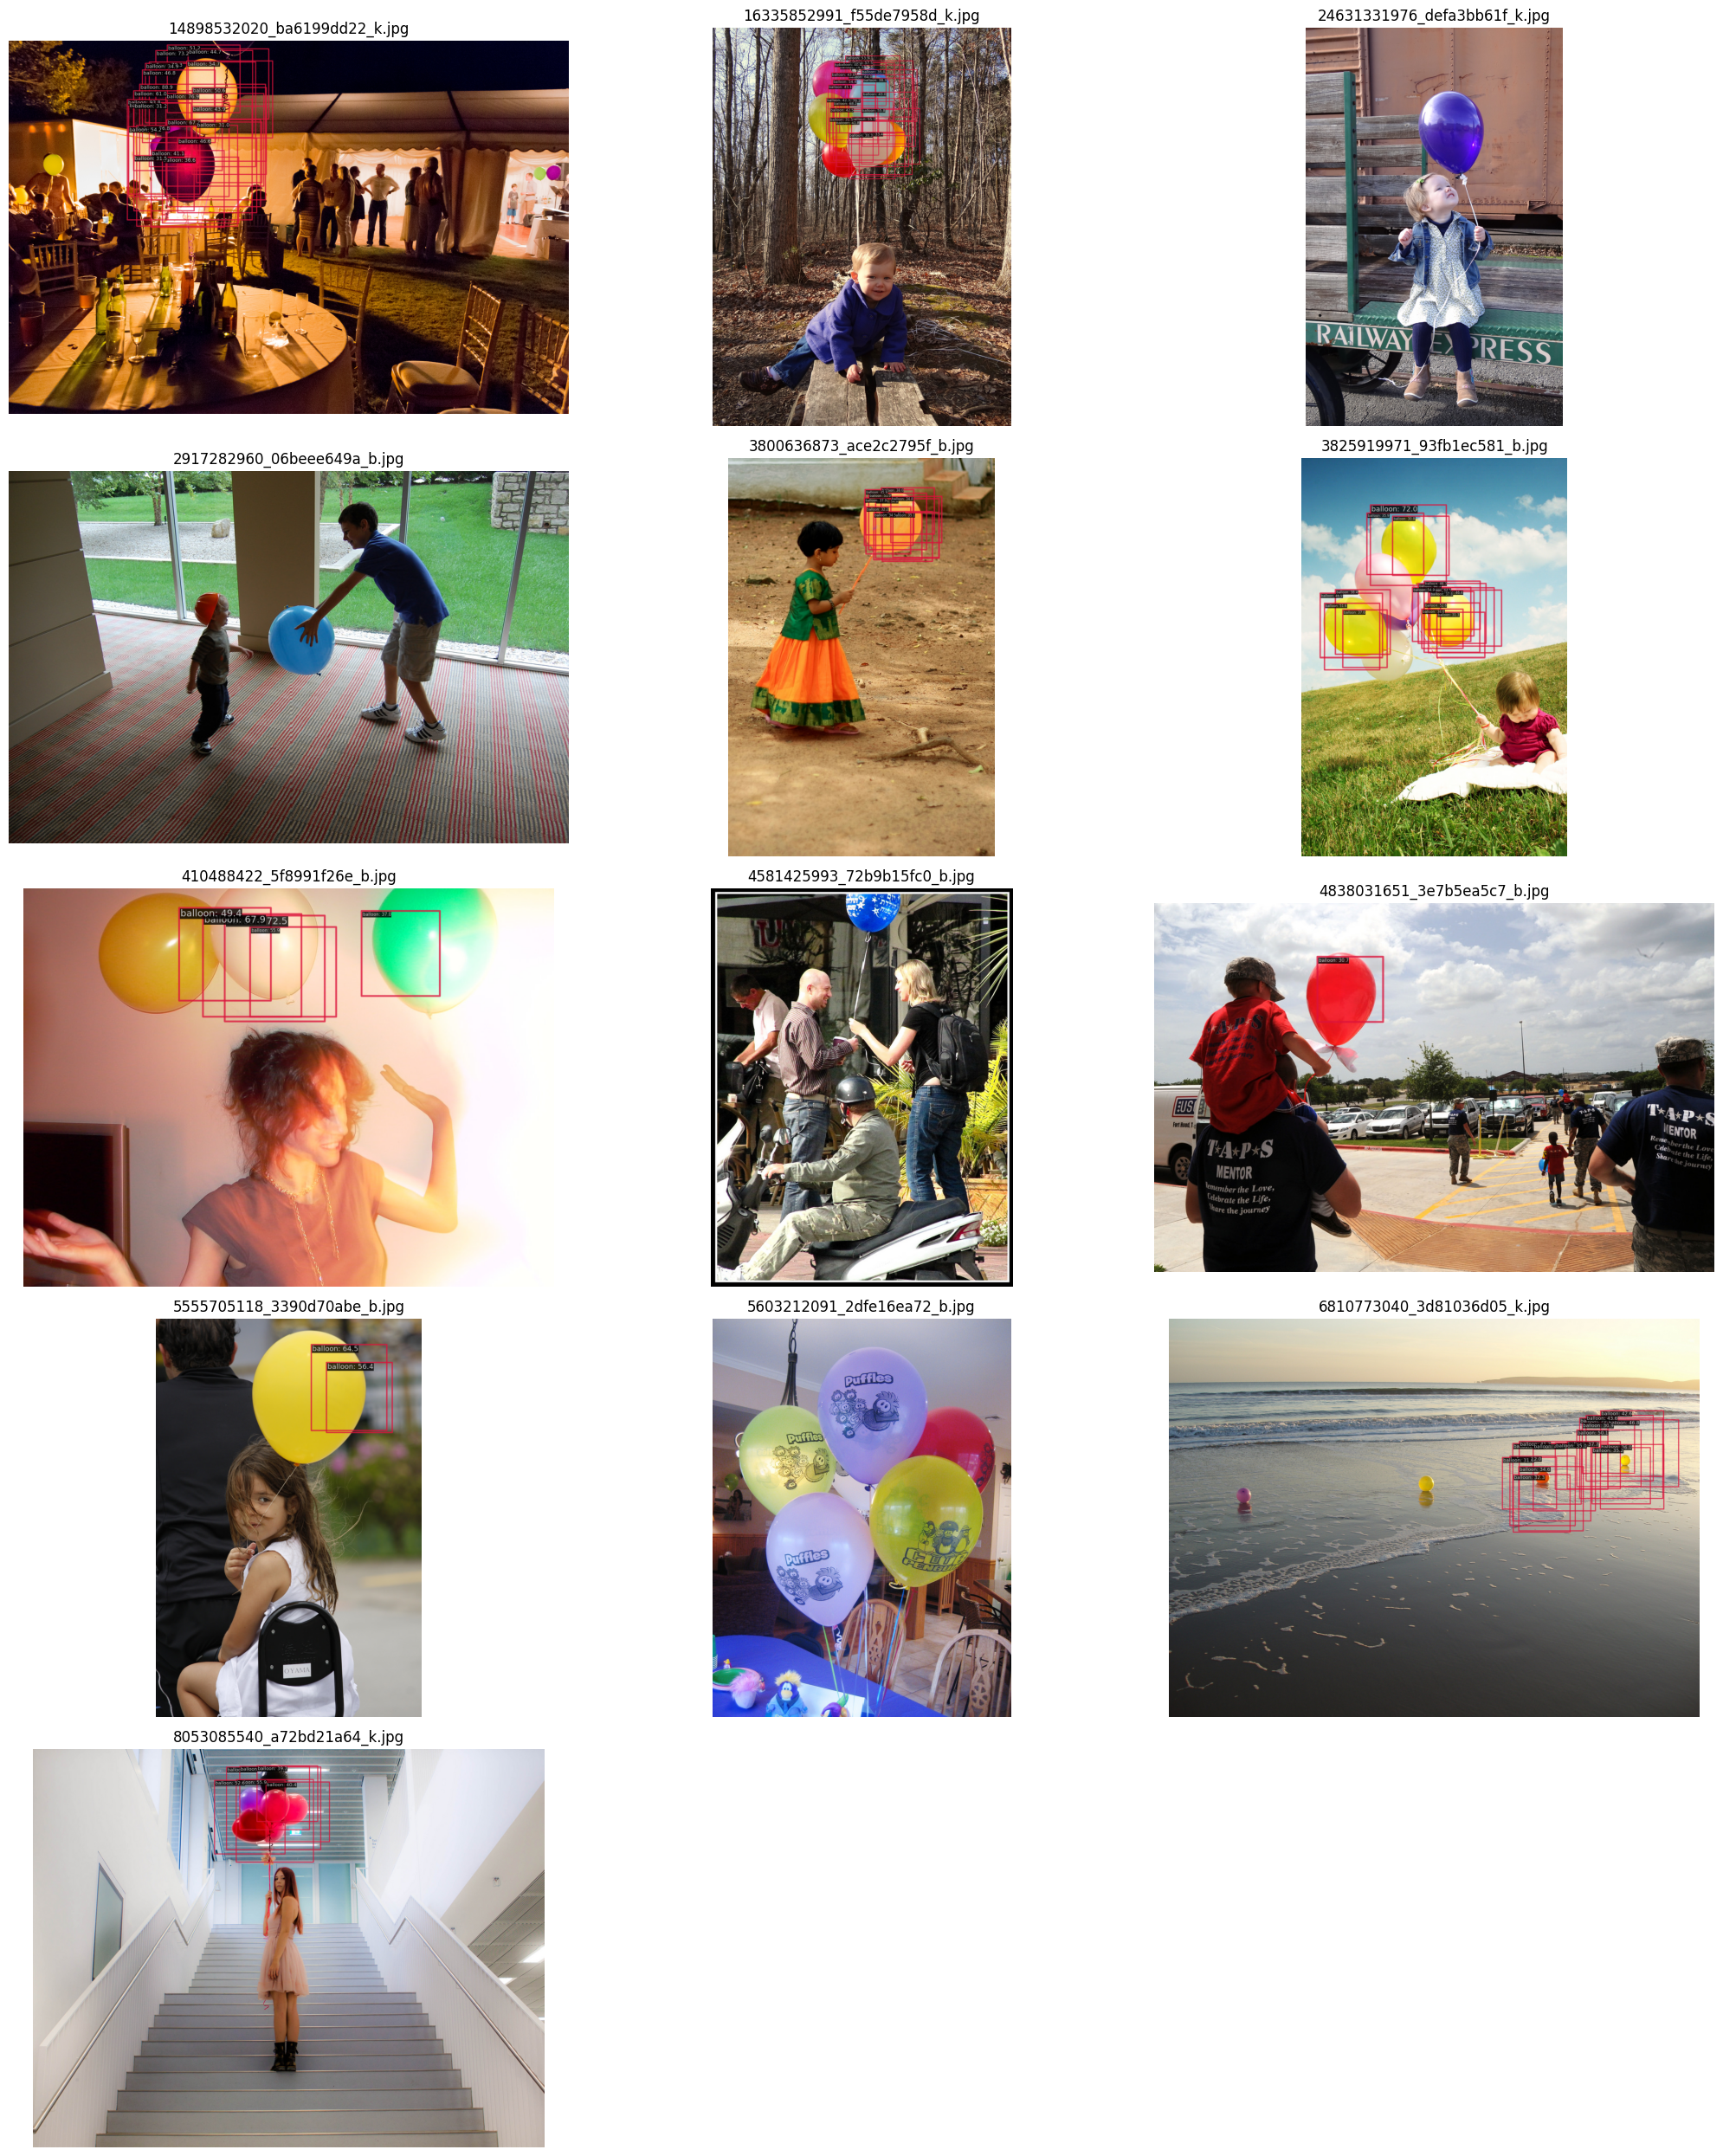

Tüm işlemler tamamlandı! Sonuç görselleri 'demo/finetune_output_results' içine kaydedildi.


In [9]:
import mmcv
import torch
from mmdet.apis import init_detector, inference_detector
from mmengine.visualization import Visualizer
import matplotlib.pyplot as plt
import os
import math

# 1. Model Checkpoint'ini yükle
# "best_coco_bbox_mAP" ile başlayan (en iyi) modeli veya son epoch'u bul
best_checkpoint = None
for file in os.listdir(cfg.work_dir):
    if file.startswith('best_coco_bbox_mAP') and file.endswith('.pth'):
        best_checkpoint = file
        break

if best_checkpoint:
    checkpoint_path = os.path.join(cfg.work_dir, best_checkpoint)
    print(f"En iyi model bulundu ve yükleniyor: {best_checkpoint}")
else:
    # Yoksa son epoch'u al (epoch_40.pth gibi)
    # Listeyi alıp sıralayalım ki en sonuncusu gelsin
    ckpts = [f for f in os.listdir(cfg.work_dir) if f.startswith('epoch_') and f.endswith('.pth')]
    if ckpts:
        ckpts.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
        checkpoint_path = os.path.join(cfg.work_dir, ckpts[-1])
        print(f"En son epoch yükleniyor: {ckpts[-1]}")
    else:
        print("HATA: Checkpoint dosyası bulunamadı!")
        checkpoint_path = None

if checkpoint_path:
    # Modelin yapısını config dosyasından oku
    config_path = f'{cfg.work_dir}/rtmdet_tiny_balloon.py'

    model = init_detector(config_path, checkpoint_path, device='cuda:0' if torch.cuda.is_available() else 'cpu')

    # 2. Val Klasöründeki Tüm Resimleri Bul
    val_path = 'data/balloon/val'
    # Sadece resim dosyalarını filtrele
    image_files = [f for f in os.listdir(val_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

    print(f"Toplam {len(image_files)} adet test görseli bulundu. İşleniyor...")

    # 3. Sonuçların Kaydedileceği Klasör
    output_dir = 'demo/finetune_output_results'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    print(f"Sonuçlar '{output_dir}' klasörüne de kaydedilecek.")

    # 4. Görselleştirme Ayarları (Grid şeklinde gösterelim)
    num_images = len(image_files)
    cols = 3  # Her satırda 3 resim
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(20, 5 * rows)) # Resim sayısına göre boyutu ayarla

    # 5. Döngü ile Hepsini Test Et
    for i, img_name in enumerate(image_files):
        img_full_path = os.path.join(val_path, img_name)
        img = mmcv.imread(img_full_path)

        # Tahmin Yap (Inference)
        result = inference_detector(model, img)

        # Görselleştirme için RGB'ye çevir
        # Visualizer RGB beklediği için BGR (cv2 default) verirsek renkler karışır (mavi ten vb.)
        img_rgb = mmcv.bgr2rgb(img)

        # Görselleştirme
        visualizer = Visualizer.get_current_instance()
        visualizer.dataset_meta = model.dataset_meta

        # Sonucu dosyaya kaydetmek için out_file parametresini dinamik veriyoruz
        out_file_path = os.path.join(output_dir, f"result_{img_name}")
        
        visualizer.add_datasample(
            'result',
            img_rgb, # RGB veriyoruz
            data_sample=result,
            draw_gt=False,
            wait_time=0,
            out_file=out_file_path # Buraya kaydet
        )

        # Sonuç resmini al
        res_img = visualizer.get_image()

        # Subplot'a çiz
        plt.subplot(rows, cols, i + 1)
        # Visualizer zaten RGB dönüyor
        plt.imshow(res_img)
        plt.title(img_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Tüm işlemler tamamlandı! Sonuç görselleri '{output_dir}' içine kaydedildi.")

## 8. Notlar: Yaşanan Problemler ve Çözümleri

Bu eğitim sürecinde karşılaşılan bazı önemli hatalar ve uygulanan çözüm yöntemleri aşağıda özetlenmiştir. Bu notlar, benzer hatalarla karşılaşılması durumunda referans olması için eklenmiştir.

| Hata / Problem | Açıklama | Çözüm |
| :--- | :--- | :--- |
| **MIM Download Hatası** | `mim.download` komutu, `.py` uzantısı içeren config adı verildiğinde `ValueError` fırlattı. | Config adından `.py` uzantısı kaldırılarak `mim.download(..., configs=['rtmdet_tiny_...'])` şeklinde çalıştırıldı. |
| **Config Yükleme** | `mim.download` bazen dosya yolunu doğru dönmeyebiliyor. Bu durumda `Config.fromfile` dosya bulunamadı hatası verdi. | Manuel olarak `rtmdet_tiny_8xb32-300e_coco.py` dosya adı kullanılarak yükleme yapıldı. |
| **RuntimeError / MemoryError** | Eğitim sırasında, özellikle 30. epoch gibi ileri aşamalarda checkpoint kaydedilirken disk doldu veya bellek hatası alındı. | Config ayarına `max_keep_ckpts = 1` eklenerek sadece **en son** modelin saklanması sağlandı (disk tasarrufu). Ayrıca eğitimin kesildiği yerden devam etmesi için `resume = True` eklendi. |
| **Multiprocessing Hatası (Windows)** | `DataLoader worker exited unexpectedly`. Windows'ta çoklu işlem (multiprocessing) sırasında worker process'in çökmesi. `num_workers` yüksek olduğunda veya bellek sınırlarında gerçekleşir. | `cfg.train_dataloader.num_workers` ve `val` için bu değer **0**'a çekildi. `0` değeri, veriyi ana işlemcide yükler; biraz daha yavaştır ama Windows'ta en güvenli/hatasız yöntemdir. |

Bu adımlar takip edilerek eğitim başarıyla tamamlanmış veya kaldığı yerden devam ettirilmiştir.